<a href="https://colab.research.google.com/github/yuji-sgs/web-optimization/blob/main/chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-916-8.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『ウェブ最適化ではじめる機械学習』（飯塚 修平　著）](https://www.oreilly.co.jp/books/9784873119168/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

# 2章: 確率的プログラミング: コンピュータの助けを借りる

In [2]:
!pip install -U arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Uninstalling arviz-0.15.1:
      Successfully uninstalled arviz-0.15.1


In [1]:
# 必要なモジュールの読み込み
import numpy as np
from matplotlib import pyplot as plt
import pymc as pm

plt.style.use('grayscale')
plt.style.use('seaborn-whitegrid')
np.random.seed(0)

<ipython-input-1-89b4c6d4cdb1>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 統計モデルの記述とサンプリングの実行

In [3]:
N = 40  # アリスのデザインA案の表示数
a = 2   # アリスのデザインA案のクリック数

with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1)
  # theta = pm.Beta('theta', alpha=1, beta=1)
  obs = pm.Binomial('a', p=theta, n=N, observed=a)
  trace = pm.sample(5000, chains=2)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba = importlib.import_module("numba")


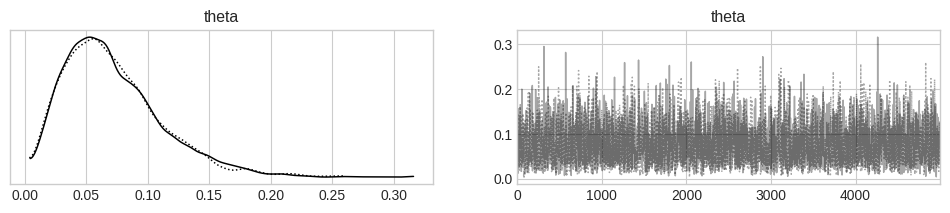

In [4]:
# 事後分布からのサンプルの可視化
with model:
  pm.plot_trace(trace)

In [5]:
with model:
  print(pm.summary(trace, hdi_prob=0.95))

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba = importlib.import_module("numba")


        mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta  0.072  0.04      0.01       0.15      0.001      0.0    3654.0   

       ess_tail  r_hat  
theta    4156.0    1.0  


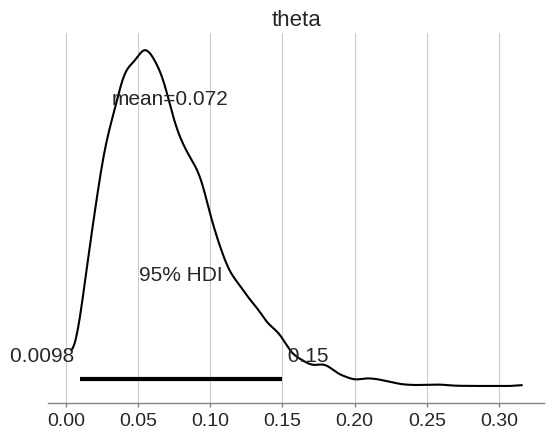

In [6]:
with model:
  pm.plot_posterior(trace, hdi_prob=0.95)

In [7]:
# 仮説：アリスのデザインA案のクリック率は1％以上である。
# 定量的評価：新たな確率変数𝛿=θ-0.01のサンプルが95%の確率で正になる。
theta_samples = trace.posterior['theta'].values.flatten()
print((theta_samples - 0.01 > 0).mean())

0.9933


### アリスのデザイン案AおよびBのクリック率のサンプルの可視化

In [21]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
  obs = pm.Binomial('obs', p=theta, n=[40, 50], observed=[2, 4])
  trace = pm.sample(5000, chains=2)

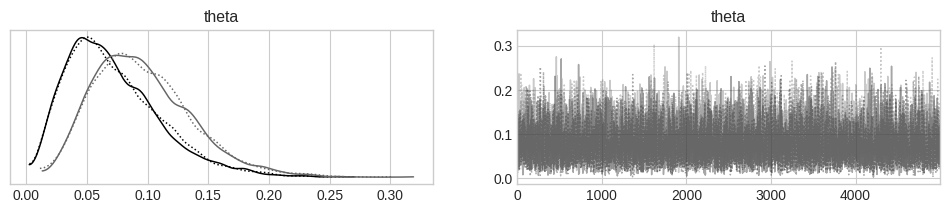

In [22]:
with model:
  pm.plot_trace(trace, ['theta'], compact=True)

In [23]:
# 仮説：B案のクリック率はA案よりも大きい
# 定量的評価：新たな確率変数𝛿=θB-θAのサンプルが95%の確率で正の値になる
theta_A = trace.posterior['theta'].sel(theta_dim_0=0).values.flatten()
theta_B = trace.posterior['theta'].sel(theta_dim_0=1).values.flatten()
print((theta_B - theta_A > 0).mean())

0.6758


### ボブのデザイン案AおよびBのクリック率のサンプルの可視化

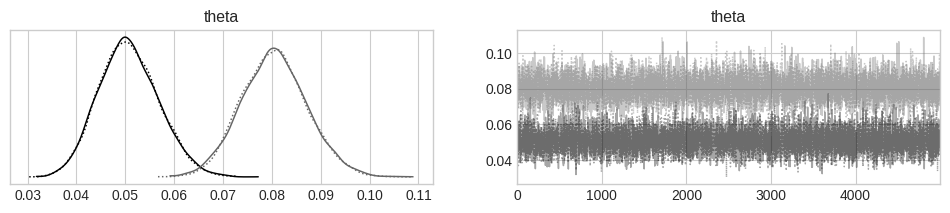

In [24]:
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=1, shape=2)
  obs = pm.Binomial('obs', p=theta, n=[1280, 1600], observed=[64, 128])
  trace = pm.sample(5000, chains=2)
  pm.plot_trace(trace, ['theta'], compact=True)

In [25]:
# 仮説：B案のクリック率はA案よりも大きい
# 定量的評価：新たな確率変数𝛿=θB-θAのサンプルが95%の確率で正の値になる
theta_A = trace.posterior['theta'].sel(theta_dim_0=0).values.flatten()
theta_B = trace.posterior['theta'].sel(theta_dim_0=1).values.flatten()
print((theta_B - theta_A > 0).mean())

0.9997


## 真のレビュースコア

In [26]:
n_a = [20, 10, 36, 91, 170]
data = [0 for _ in range(n_a[0])]
data += [1 for _ in range(n_a[1])]
data += [2 for _ in range(n_a[2])]
data += [3 for _ in range(n_a[3])]
data += [4 for _ in range(n_a[4])]

with pm.Model() as model_a:
  theta = pm.Dirichlet('theta', a=np.array([1, 1, 1, 1, 1]))
  obs = pm.Categorical('obs', p=theta, observed=data)
  trace_a = pm.sample(5000, chains=2)

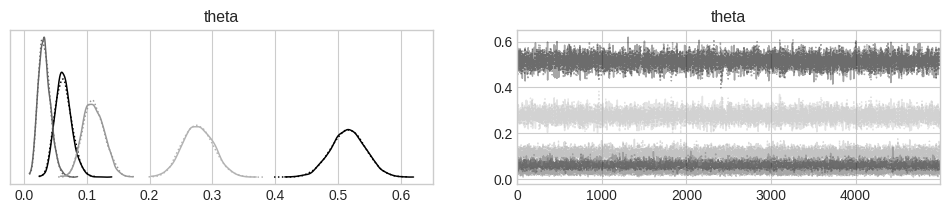

In [28]:
with model_a:
  pm.plot_trace(trace_a)

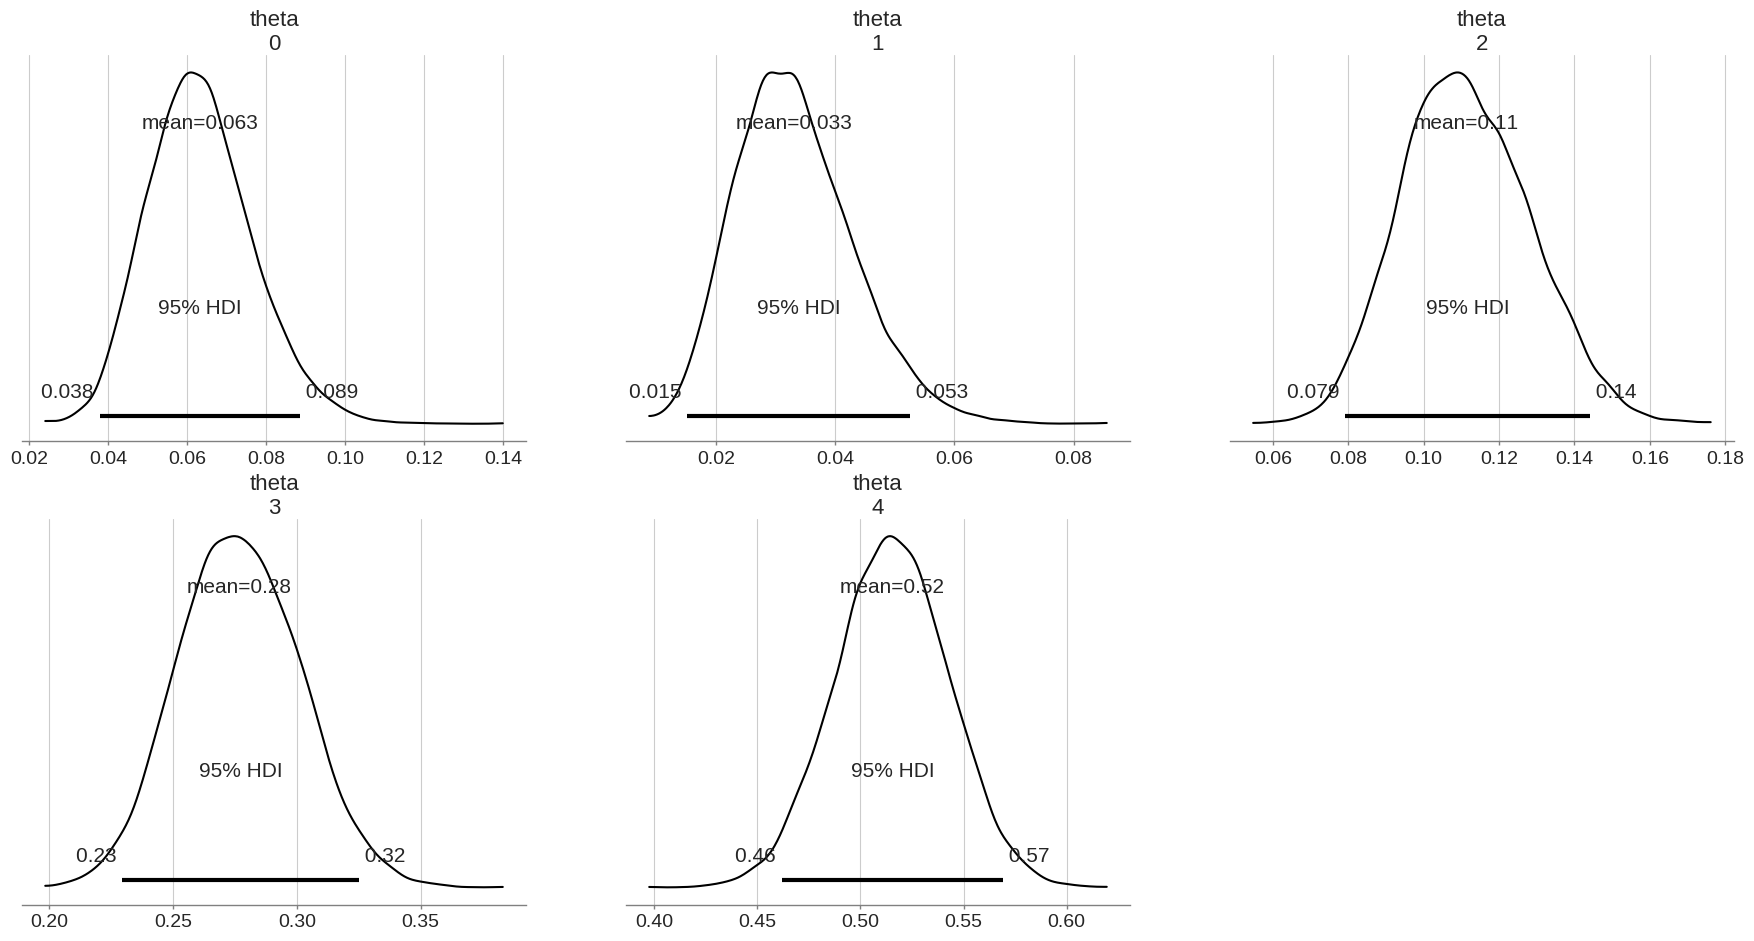

In [30]:
# 商品Aについて各レビュースコアが生み出される確率  𝜽  の事後分布の可視化
with model_a:
  pm.plot_posterior(trace_a, hdi_prob=0.95)

In [80]:
# レビュースコアの平均点に相当する新たな確率変数m_a
weights = np.array([1, 2, 3, 4, 5])
m_a = [0] * 10000
for i in range(len(weights)):
  score = weights[i] * trace_a.posterior['theta'].sel(theta_dim_0=i).values.flatten()
  m_a += score

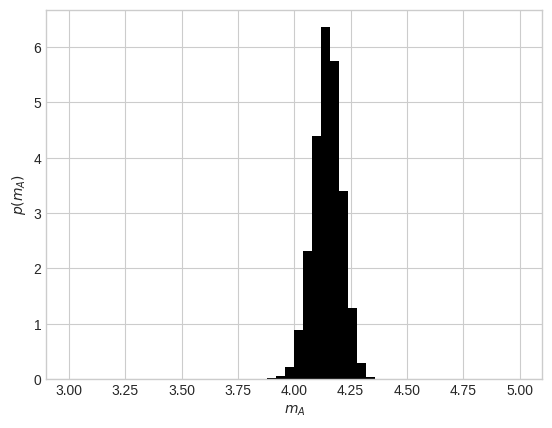

In [81]:
# 商品Aに対するレビュースコアの平均点  𝑚  の確率密度関数
plt.hist(m_a, range=(3, 5), bins=50, density=True)
plt.xlabel(r'$m_A$')
plt.ylabel(r'$p(m_A)$')
plt.show()

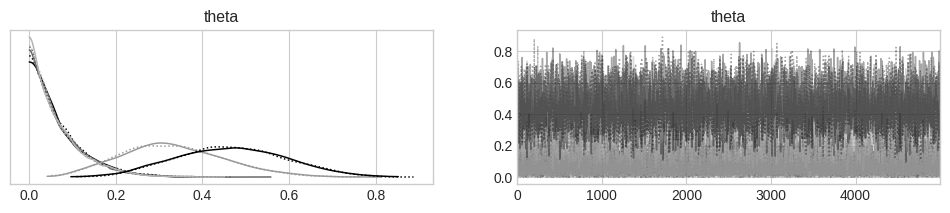

In [75]:
# 商品Bについて各レビュースコアが生み出される確率  𝜽  のサンプルの可視化
n_b = np.array([0, 0, 4, 0, 6])
with pm.Model() as model_b:
  theta = pm.Dirichlet('theta', a=np.array([1, 1, 1, 1, 1]))
  obs = pm.Multinomial('obs', p=theta, n=n_b.sum(), observed=n_b)
  trace_b = pm.sample(5000, chains=2)
  pm.plot_trace(trace_b)

In [82]:
# レビュースコアの平均点に相当する新たな確率変数m_b
weights = np.array([1, 2, 3, 4, 5])
m_b = [0] * 10000
for i in range(len(weights)):
  score = weights[i] * trace_b.posterior['theta'].sel(theta_dim_0=i).values.flatten()
  m_b += score

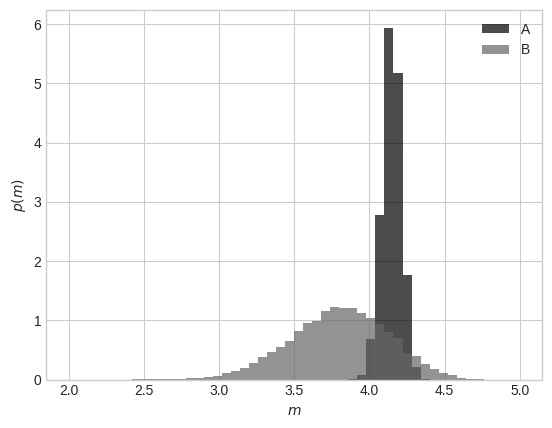

In [84]:
# 商品AとBのレビュースコアの平均点の確率密度関数
plt.hist(m_a, range=(2, 5), bins=50, density=True, label='A',
         alpha=0.7)
plt.hist(m_b, range=(2, 5), bins=50, density=True, label='B',
         alpha=0.7)
plt.xlabel(r'$m$')
plt.ylabel(r'$p(m)$')
plt.legend()
plt.show()

## 滞在時間をテストする

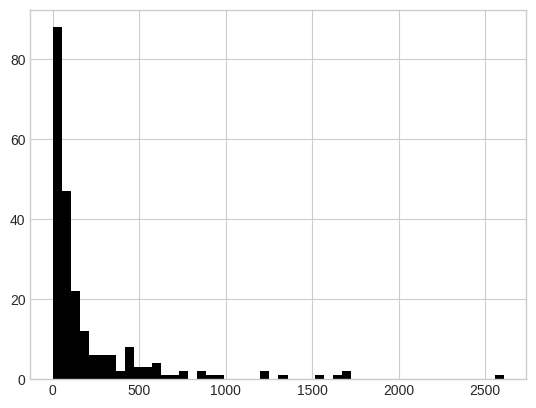

In [87]:
# あるウェブサイトにおける滞在時間（秒）のヒストグラム
import urllib
url = 'https://www.oreilly.co.jp/pub/9784873119168/data/time-on-page.csv'
response = urllib.request.urlopen(url)
data = [int(row.strip()) for row in response.readlines()]
plt.hist(data, bins=50)
plt.show()

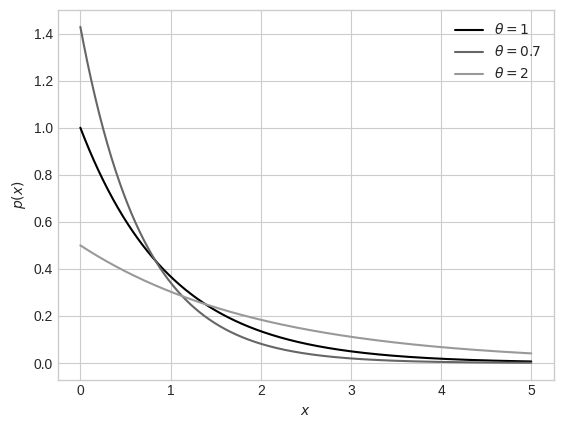

In [89]:
# さまざまな指数分布の例
from scipy import stats
xs = np.linspace(0, 5, 1001)
plt.plot(xs, stats.expon.pdf(xs, 0, 1), label=r'$\theta = 1$')
plt.plot(xs, stats.expon.pdf(xs, 0, 0.7), label=r'$\theta = 0.7$')
plt.plot(xs, stats.expon.pdf(xs, 0, 2), label=r'$\theta = 2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.legend()
plt.show()

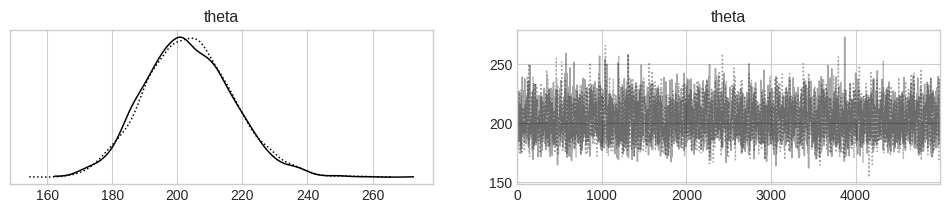

In [91]:
# 確率変数  𝜃  のサンプルの軌跡
with pm.Model() as model:
  theta = pm.Uniform('theta', lower=0, upper=3000)
  obs = pm.Exponential('obs', lam=1/theta, observed=data)
  trace = pm.sample(5000, chains=2)
  pm.plot_trace(trace)

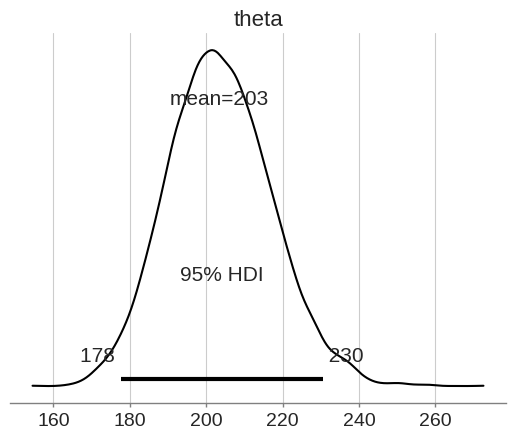

In [92]:
# 確率変数  𝜃  の事後分布
with model:
  pm.plot_posterior(trace, hdi_prob=0.95)

**ある操作を加えることでWebサイトの滞在時間がのび太ことを確かめたいのなら、この確率変数θの事後分布から導き出される統計量を比較して定量的に評価すれば良い。**

## なぜベイズ推論による統計的仮説検定を行うか

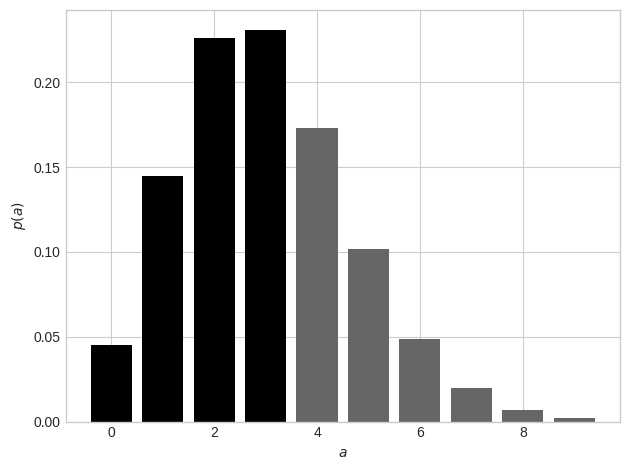

In [93]:
# アリスのレポートにおけるクリック数の標本分布。 合計クリック数  𝑎  が4以上となる部分を異なる色で示した。
x = 10
N = 50
theta = 0.06
thres = 4
plt.bar(range(thres), stats.binom.pmf(range(thres), N, theta), linewidth=0)
plt.bar(range(thres, x), stats.binom.pmf(range(thres, x), N, theta), linewidth=0)
plt.xlabel(r'$a$')
plt.ylabel(r'$p(a)$')
plt.tight_layout()
plt.show()

In [95]:
# 𝑎  が thres 以上の値を取る確率
stats.binom.pmf(range(thres, 10000), N, theta).sum()

0.35269662790368267

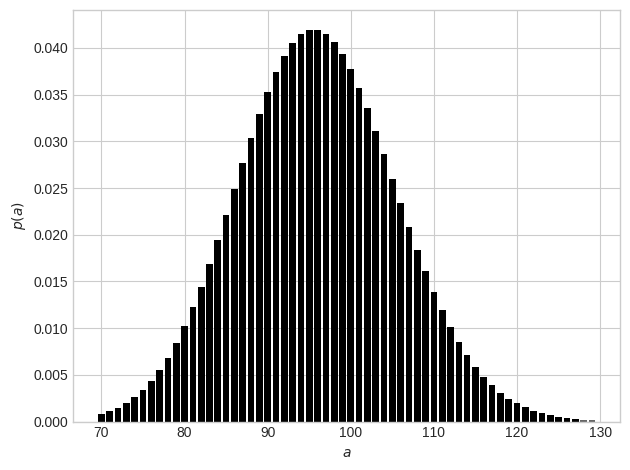

In [96]:
# ボブのレポートにおけるクリック数の標本分布。合計クリック数  𝑎  が128以上となる部分を異なる色で示した。
minx = 70
x = 130
N = 1600
theta = 0.06
thres = 128
plt.bar(range(minx, thres), stats.binom.pmf(range(minx, thres), N, theta), linewidth=0)
plt.bar(range(thres, x), stats.binom.pmf(range(thres, x), N, theta), linewidth=0)
plt.xlabel(r'$a$')
plt.ylabel(r'$p(a)$')
plt.tight_layout()
plt.show()

In [97]:
# 𝑎  が thres 以上の値を取る確率
stats.binom.pmf(range(thres, 10000), N, theta).sum()

0.0007341521761379321